# WEATHER data from Warsaw station

In [2]:
import pandas as pd
from matplotlib import pyplot
import seaborn as sn
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import datetime as dt
import numpy as np

from tensorflow import keras


# Read the CSV file
all_data = pd.read_csv("data_lodz.csv")

C:\Users\mirgo\AppData\Local\Temp\ipykernel_17744\925180121.py:13: DtypeWarning: Columns (4,6,27) have mixed types. Specify dtype option on import or set low_memory=False.
  all_data = pd.read_csv("data_lodz.csv")


In [3]:
import warnings
warnings.filterwarnings("ignore") #:D

### Note - columns:

valid:
timestamp of the observation - every half hour

tmpf:
Air Temperature in Fahrenheit

relh:
Relative Humidity in %

drct:
Wind Direction in degrees from *true* north

sknt:
Wind Speed in knots

p01i:
One hour precipitation for the period from the observation time to the time of the previous hourly precipitation reset. This varies slightly by site. Values are in inches. This value may or may not contain frozen precipitation melted by some device on the sensor or estimated by some other means. Unfortunately, we do not know of an authoritative database denoting which station has which sensor.



In [4]:
df_with_direct = all_data[["valid", "tmpf", "relh", "drct", "sknt","p01i"]]

df_with_direct=df_with_direct.replace('M', np.nan)

nan_count = df_with_direct.isna().sum()

print(nan_count)

valid        0
tmpf         0
relh        84
drct     16504
sknt         1
p01i         0
dtype: int64


In [5]:
# drct deletion
df = df_with_direct.copy()
df.drop('drct',axis='columns', inplace=True)

# 'tmpf' NaN into data from previous timestamp
bool_df = df['tmpf'].isnull()
indexes = df[bool_df].index
for i in indexes:
    df['tmpf'][i]=df['tmpf'][i-1]

# 'tmpf' NaN into data from previous timestamp
bool_df = df['relh'].isnull()
indexes = df[bool_df].index
for i in indexes:
    df['relh'][i]=df['relh'][i-1]

# 'tmpf' NaN into data from previous timestamp
bool_df = df['sknt'].isnull()
indexes = df[bool_df].index
for i in indexes:
    df['sknt'][i]=df['sknt'][i-1]

nan_count = df.isna().sum()

print(nan_count)

valid    0
tmpf     0
relh     0
sknt     0
p01i     0
dtype: int64


In [6]:
#Fahrenheit => Celsius

df['tmpf'] = df['tmpf'].astype(float)
df['relh'] = df['relh'].astype(float)
df['sknt'] = df['sknt'].astype(float)
df = df.assign(temp = lambda x: (5/9)*(x['tmpf']-32))
df.drop('tmpf',axis='columns', inplace=True)

# date
df['valid']=pd.to_datetime(df['valid'])
df['day'] = df['valid'].dt.day
df['month'] = df['valid'].dt.month
df['year'] = df['valid'].dt.year
df['time'] = df['valid'].dt.time

dates = df['valid']

df.drop('valid',axis='columns', inplace=True)


df.head()

,relh,sknt,p01i,temp,day,month,year,time
0,92.97,10.0,0.0,0.0,1,1,2015,01:00:00
1,92.97,8.0,0.0,0.0,1,1,2015,01:30:00
2,100.00,7.0,0.0,0.0,1,1,2015,02:00:00
3,100.00,7.0,0.0,0.0,1,1,2015,02:30:00
4,100.00,7.0,0.0,0.0,1,1,2015,03:00:00


### from 2015 to 2021 weather : 2022 for validation

In [13]:
# for learning
df_2015_2021 = df[(df['year'] <= 2021)]
# dates_2015_2021 = dates[df['year'] <= 2021]

# for validation
df_2022 = df[(df['year'] == 2022)]
# dates_2022 = dates[df['year'] == 2022]

# VARIMAX model

In [39]:
def gethour(x):
    return x.hour

In [80]:
#xgboost
x_train_xgb = df_2015_2021[["relh", "sknt", "day", "month", "year", "time"]]
x_train_xgb["hour"]=np.vectorize(gethour)(x_train_xgb["time"])
x_train_xgb = x_train_xgb.iloc[::2, :].reset_index(names='index', drop=True) 
x_train_xgb.drop(axis="columns", inplace=True,labels="time")

#x_train_xgb["time"]=int(datetime.datetime.timestamp(datetime.datetime.utcnow()))
y_train_xgb = x_train_xgb.iloc[2:]
#y_train_xgb.drop(axis="columns", inplace=True,labels=["day", "month", "year", "hour"])
x_train_xgb = x_train_xgb.iloc[:-2]

x_test_xgb = df_2022[["relh", "sknt", "day", "month", "year", "time"]]
x_test_xgb["hour"]=np.vectorize(gethour)(x_test_xgb["time"])
x_test_xgb = x_test_xgb.iloc[::2, :].reset_index(names='index', drop=True) 
x_test_xgb.drop(axis="columns", inplace=True,labels="time")

y_test_xgb = x_test_xgb.iloc[2:]
#y_test_xgb.drop(axis="columns", inplace=True,labels=["day", "month", "year", "hour"])
x_test_xgb = x_test_xgb.iloc[:-2]
#int(pd.Timestamp(datetime.datetime.timestamp(x_train_xgb["time"][0].time)))
#x_train_xgb["hour"]=np.vectorize(gethour)(x_train_xgb["time"])
#x_train_xgb = x_train_xgb.iloc[::2, :].reset_index(names='index', drop=True) 
#x_train_xgb.drop(axis="columns", inplace=True,labels="time")
x_train_xgb, y_train_xgb, x_test_xgb, y_test_xgb

(         relh  sknt  day  month  year  hour
 0       92.97  10.0    1      1  2015     1
 1      100.00   7.0    1      1  2015     2
 2      100.00   7.0    1      1  2015     3
 3       93.03   6.0    1      1  2015     4
 4      100.00   7.0    1      1  2015     5
 ...       ...   ...  ...    ...   ...   ...
 61253   87.37  14.0   31     12  2021    17
 61254   81.74  13.0   31     12  2021    18
 61255   87.37  11.0   31     12  2021    19
 61256   87.37  12.0   31     12  2021    20
 61257   93.50  19.0   31     12  2021    21
 
 [61258 rows x 6 columns],
          relh  sknt  day  month  year  hour
 2      100.00   7.0    1      1  2015     3
 3       93.03   6.0    1      1  2015     4
 4      100.00   7.0    1      1  2015     5
 5      100.00   8.0    1      1  2015     6
 6      100.00   8.0    1      1  2015     7
 ...       ...   ...  ...    ...   ...   ...
 61255   87.37  11.0   31     12  2021    19
 61256   87.37  12.0   31     12  2021    20
 61257   93.50  19.0   31 

In [69]:
import xgboost as xgb

In [82]:
reg = xgb.XGBRegressor(
        tree_method="hist",
        n_estimators=100,
        n_jobs=16,
        max_depth=9,
        multi_strategy="multi_output_tree",
        subsample=0.6,
    )
reg.fit(y_train_xgb, y_train_xgb, eval_set=[(x_test_xgb, y_test_xgb)])

[0]	validation_0-rmse:522.28069
[1]	validation_0-rmse:366.09872
[2]	validation_0-rmse:256.76920
[3]	validation_0-rmse:180.24759
[4]	validation_0-rmse:126.70451
[5]	validation_0-rmse:89.23136
[6]	validation_0-rmse:63.02562
[7]	validation_0-rmse:44.71443
[8]	validation_0-rmse:31.90936
[9]	validation_0-rmse:22.92645
[10]	validation_0-rmse:16.68582
[11]	validation_0-rmse:12.45264
[12]	validation_0-rmse:9.53349
[13]	validation_0-rmse:7.70180
[14]	validation_0-rmse:6.55573
[15]	validation_0-rmse:5.83077
[16]	validation_0-rmse:5.46005
[17]	validation_0-rmse:5.23647
[18]	validation_0-rmse:5.08876
[19]	validation_0-rmse:5.03122
[20]	validation_0-rmse:4.98964
[21]	validation_0-rmse:4.96682
[22]	validation_0-rmse:4.94951
[23]	validation_0-rmse:4.93566
[24]	validation_0-rmse:4.93382
[25]	validation_0-rmse:4.92522
[26]	validation_0-rmse:4.92458
[27]	validation_0-rmse:4.92017
[28]	validation_0-rmse:4.91781
[29]	validation_0-rmse:4.91370
[30]	validation_0-rmse:4.91506
[31]	validation_0-rmse:4.91433
[

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy='multi_output_tree', n_estimators=100, n_jobs=16,
             num_parallel_tree=None, random_state=None, ...)

In [85]:
y_pred_xgb = reg.predict(x_test_xgb)
reg.predict(x_test_xgb[:1]), y_test_xgb[:1]

(array([[9.4080475e+01, 1.0883345e+01, 1.9411920e+00, 1.6623348e+00,
         2.0206320e+03, 8.9981365e-01]], dtype=float32),
    relh  sknt  day  month  year  hour
 2  93.5  13.0    1      1  2022     2)

In [90]:
y_pred_xgb = pd.DataFrame(y_pred_xgb, columns=[ "relh",  "sknt",  "day" ,"month" ,"year","hour"])
y_pred_xgb

,relh,sknt,day,month,year,hour
0,94.080475,10.883345,1.941192,1.662335,2020.631958,0.899814
1,93.923592,12.501115,1.520684,1.260463,2020.709106,1.835900
2,93.634865,12.272711,1.212743,1.328445,2020.778564,2.933064
3,93.452248,12.789076,0.717216,0.853193,2020.921875,4.067812
4,93.877007,12.530377,1.241076,1.005983,2021.033691,4.702479
...,...,...,...,...,...,...
8723,81.441231,1.232212,29.928255,11.751855,2020.971924,16.841980
8724,86.719627,1.310800,29.665220,12.082651,2020.606079,17.862232
8725,86.744316,2.278478,30.059347,11.925141,2020.632080,19.190674
8726,93.424187,2.845551,30.122847,11.584694,2021.296509,19.627686


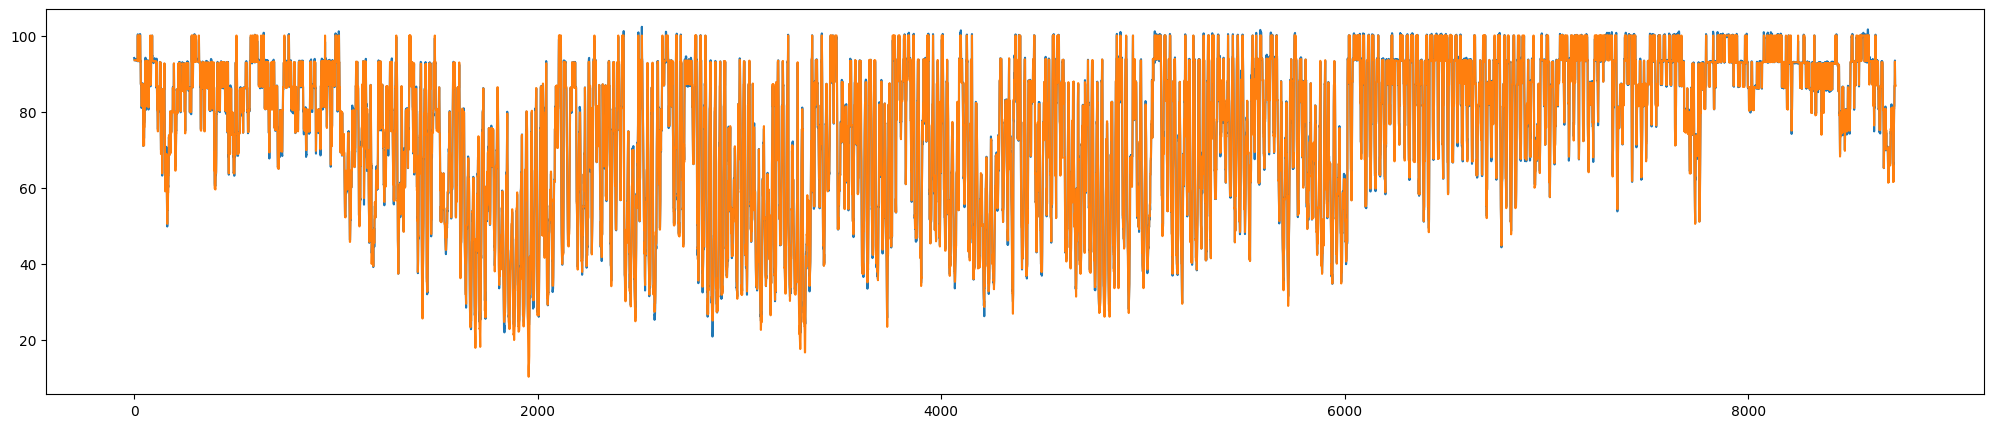

In [94]:
f = plt.figure() 
f.set_figwidth(25) 
f.set_figheight(5) 
plt.plot(y_pred_xgb[["relh"]])
plt.plot(y_test_xgb[["relh"]]) 

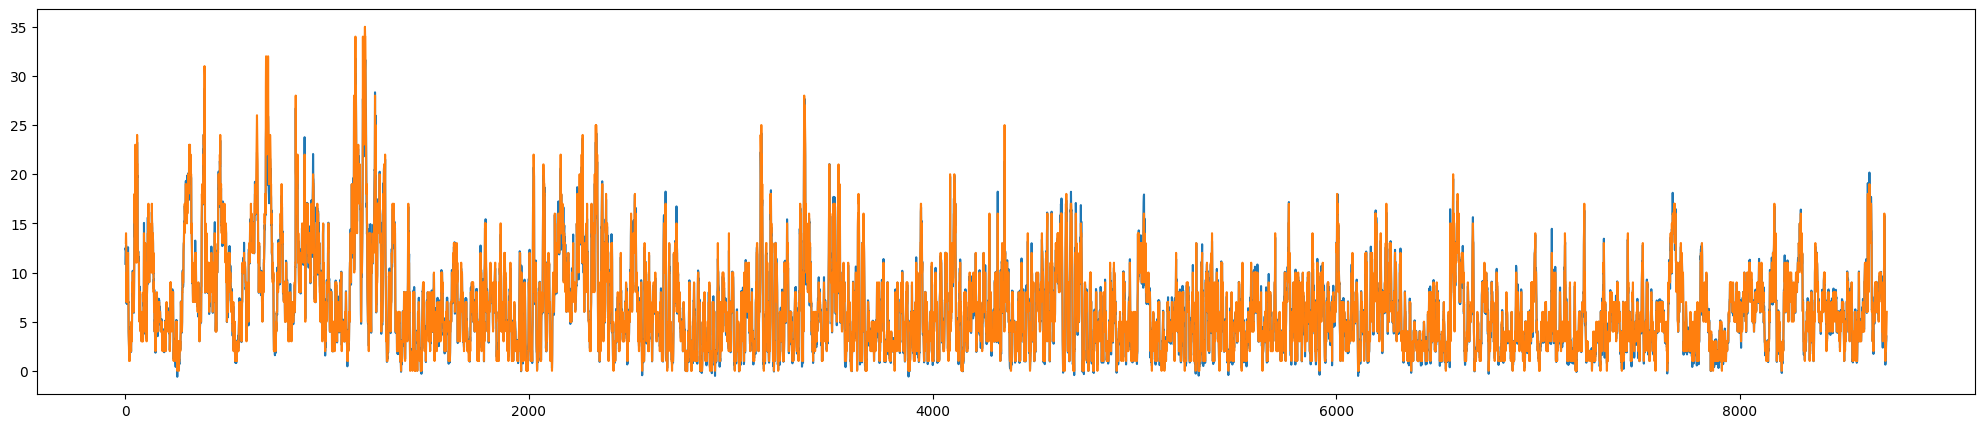

In [95]:
f = plt.figure() 
f.set_figwidth(25) 
f.set_figheight(5) 
plt.plot(y_pred_xgb[["sknt"]])
plt.plot(y_test_xgb[["sknt"]]) 